In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
from utils import read_filenames, prepare_datasets
from clustering import count_wcss_scores, count_clustering_scores, create_groups, plot_clusters, plot_random_images_from_cluster

In [2]:
path = '/Users/michal/Documents/studia/sem4/WdUM/Galaxies_Clusterization/data/images'
#path = '/Users/julia/Desktop/semestr-4/ml/projekty/projekt-2/galaxies_data/images_gz2/images'

galaxies = read_filenames(path)
galaxies_train, galaxies_val, galaxies_test = prepare_datasets(galaxies, 100000)

### Loading feature vectors created in processing stage

These are 4 different datasets created using 4 different approaches that we took during processing stage.

In [3]:
x_vgg = np.load('../processing/feature_vectors_vgg.npy')
x_simple_conv = np.load('../processing/feature_vectors_simple.npy')
x_hog = np.load('../processing/feature_vectors_hog.npy')
x_masks = np.load('../processing/feature_vectors_no_autoencoder.npy')

In [10]:
print(f'Shape of x_vgg: {x_vgg.shape}')
print(f'Shape of x_simple_conv: {x_simple_conv.shape}')
print(f'Shape of x_hog: {x_hog.shape}')
print(f'Shape of x_masks: {x_masks.shape}')

Shape of x_vgg: (10000, 22)
Shape of x_simple_conv: (10000, 18)
Shape of x_hog: (10000, 46)
Shape of x_masks: (10000, 31)


## Determining the number of clusters for Kmeans

### Within-cluster sum of squares method

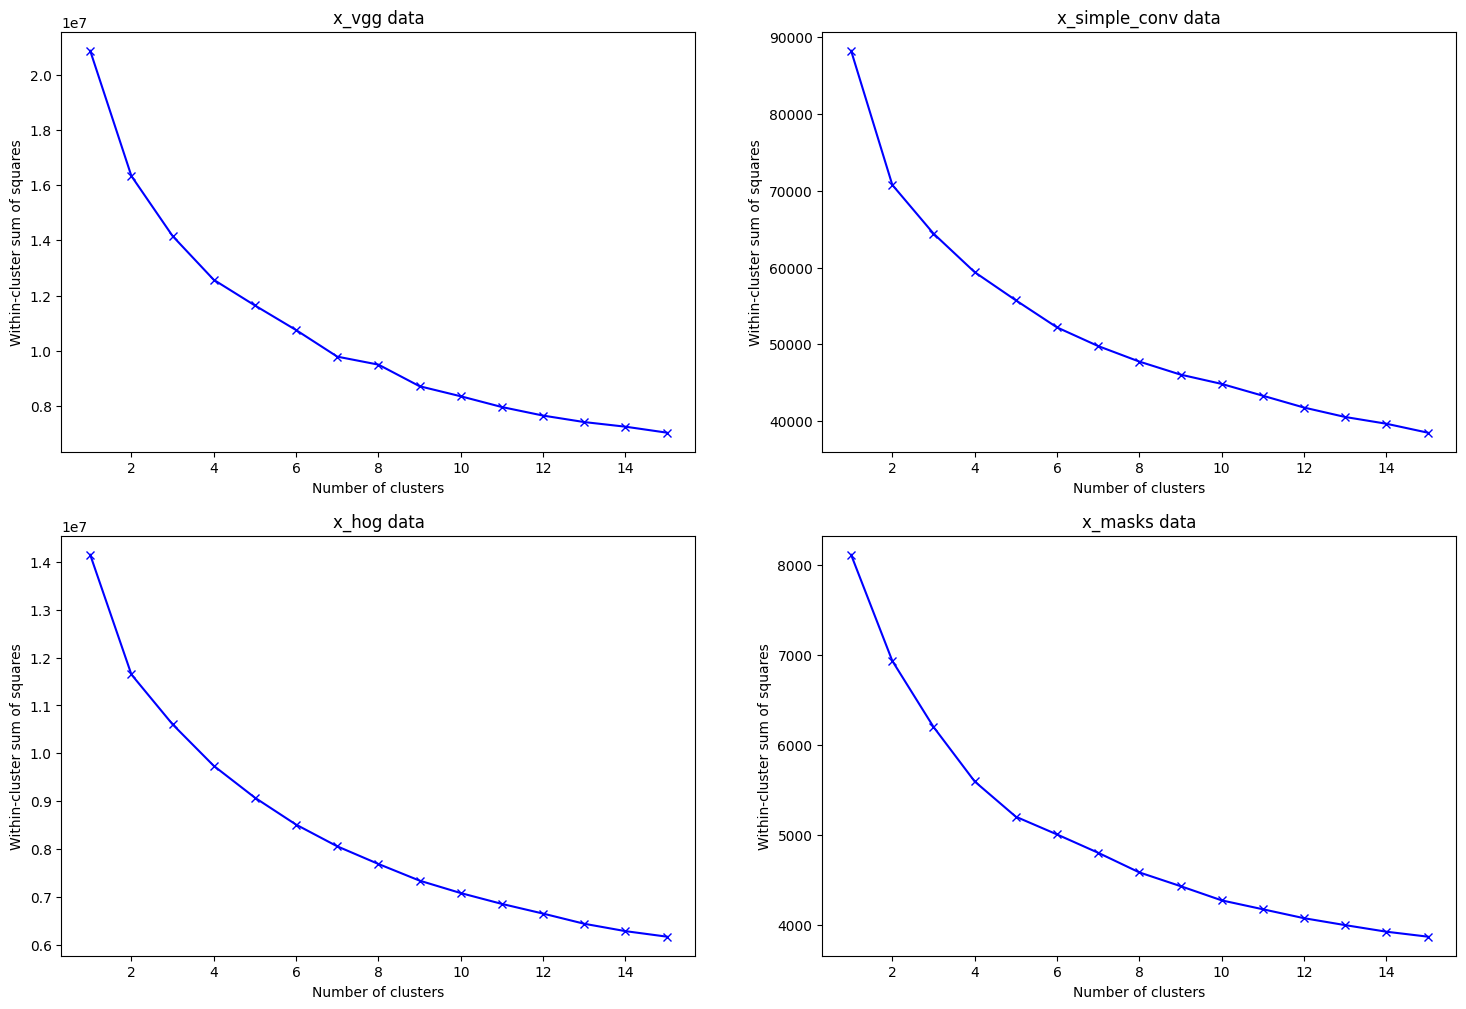

In [4]:
plt.figure(figsize=(18, 12))
names = ['x_vgg', 'x_simple_conv', 'x_hog', 'x_masks']

for i, data in enumerate([x_vgg, x_simple_conv, x_hog, x_masks]):
    plt.subplot(2, 2, i + 1)
    wcss = count_wcss_scores(data, 15)
    x_ticks = list(range(1, len(wcss) + 1))
    plt.plot(x_ticks, wcss, 'bx-')   
    plt.xlabel('Number of clusters')
    plt.ylabel('Within-cluster sum of squares')
    plt.title(f'{names[i]} data')

Elbows

1. For x_vgg at 2 or 7 clusters
2. For x_simple_conv at 2 clusters
3. For x_hog also at 2 clusters
4. For x_masks at 5 clusters

Lets check another metric - silhouette method.

### Silhouette method

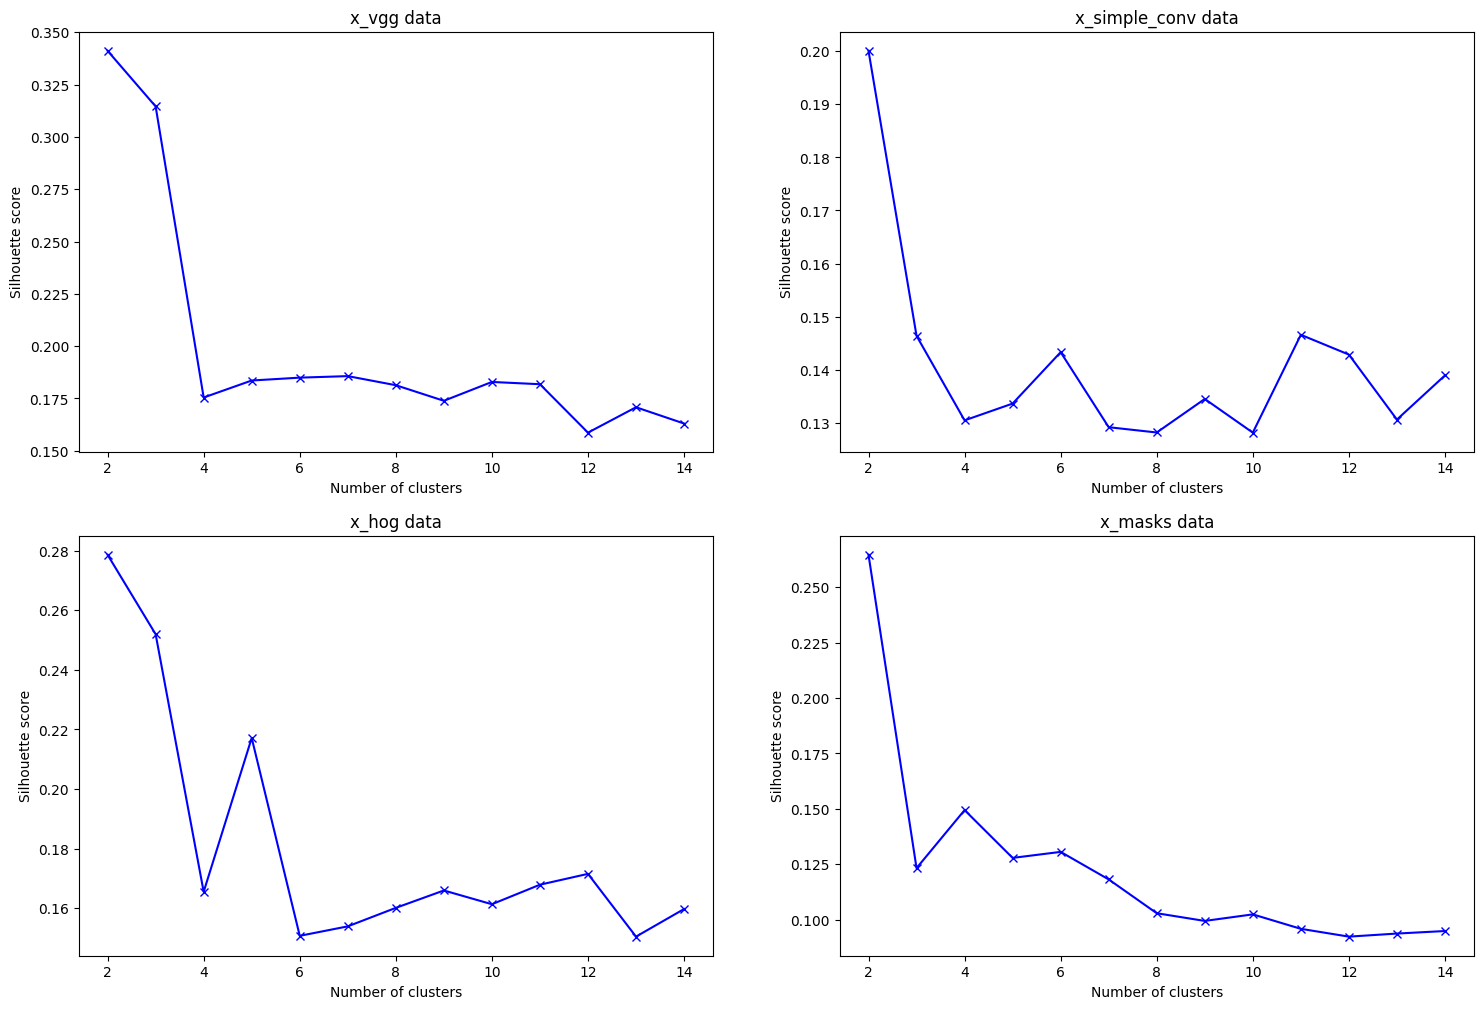

In [18]:
plt.figure(figsize=(18, 12))
names = ['x_vgg', 'x_simple_conv', 'x_hog', 'x_masks']
cluster_num_seq = range(2, 15)

for i, data in enumerate([x_vgg, x_simple_conv, x_hog, x_masks]):
    plt.subplot(2, 2, i + 1)
    silhouette_vec = count_clustering_scores(data, cluster_num_seq, KMeans, silhouette_score)
    plt.plot(cluster_num_seq, silhouette_vec, 'bx-')   
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.title(f'{names[i]} data')

Analyzing Results:

1. For x_vgg data, the silhouette score is maximized at 2 clusters but remains relatively high for 3 clusters before dropping significantly.
2. For x_simple_conv data, the silhouette score is maximized at 2 clusters and then drops significantly.
3. For x_hog data, the silhouette score is highest for 2 and 3 clusters, with an additional peak value at 5 clusters.
4. For x_masks data, the silhouette score suggests that 2 or 4 clusters are optimal.

Testing different options and considering both metrics and visual interpretability of clusters, we chose to further investigate 3-cluster KMeans for x_vgg and x_hog, and 4-cluster KMeans for x_masks.

### 3-cluster KMeans for x_vgg

In [4]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x_vgg)

KMeans(n_clusters=3, random_state=42)

In [5]:
groups = create_groups(galaxies_train, x_vgg, kmeans.labels_)

Lets see cardinality of each cluster.

In [6]:
print([len(groups[i]) for i in range(kmeans.get_params()['n_clusters'])])

[1079, 2072, 6849]


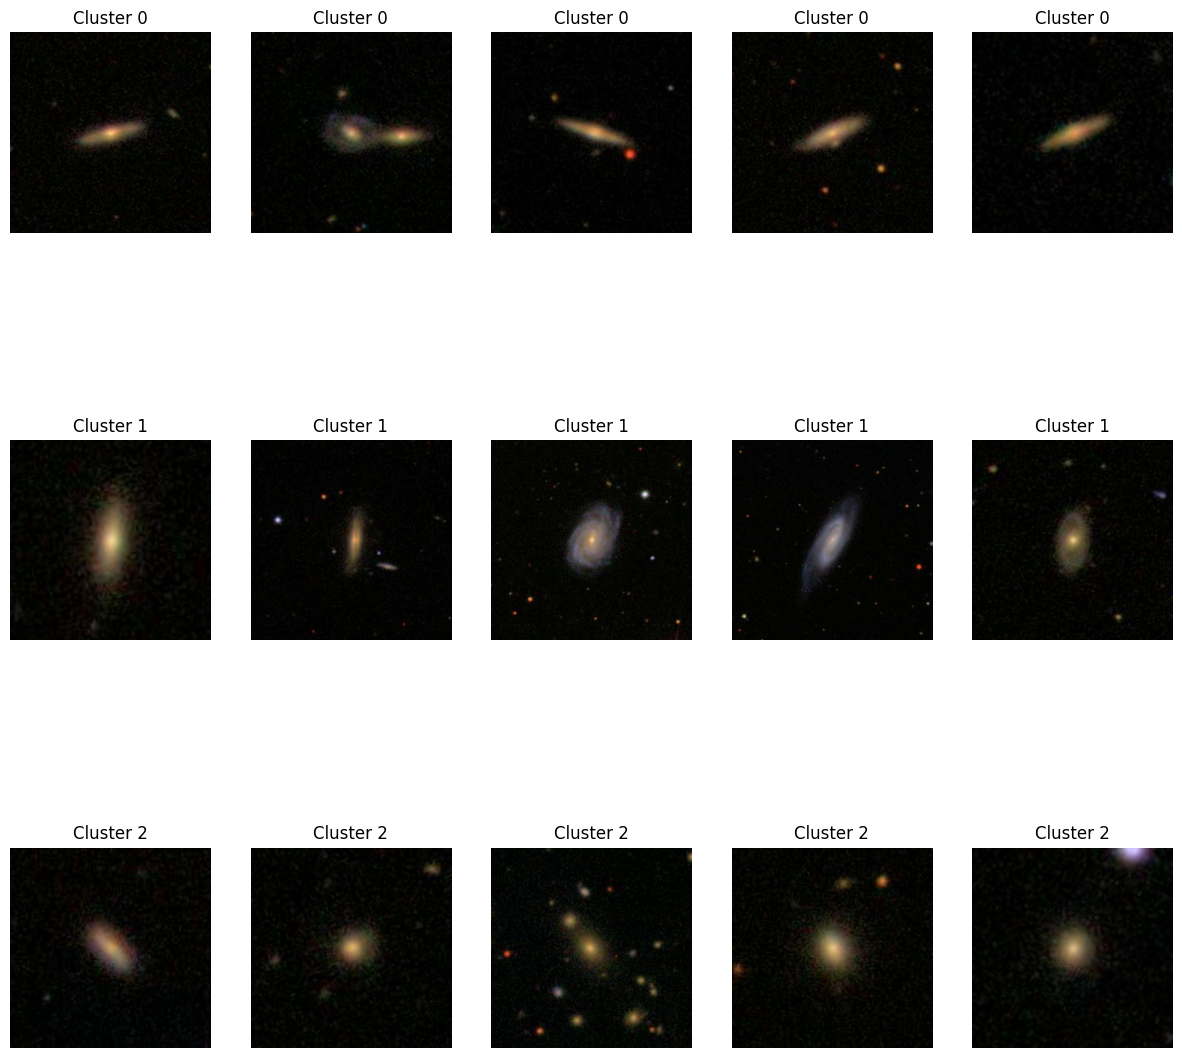

In [12]:
plot_clusters(groups)

### 3-cluster KMeans for x_hog

In [25]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(x_hog)

groups = create_groups(galaxies_train, x_vgg, kmeans.labels_)
print('Cardinality of clusters:')
print([len(groups[i]) for i in range(kmeans.get_params()['n_clusters'])])

Cardinality of clusters:
[6088, 1891, 2021]


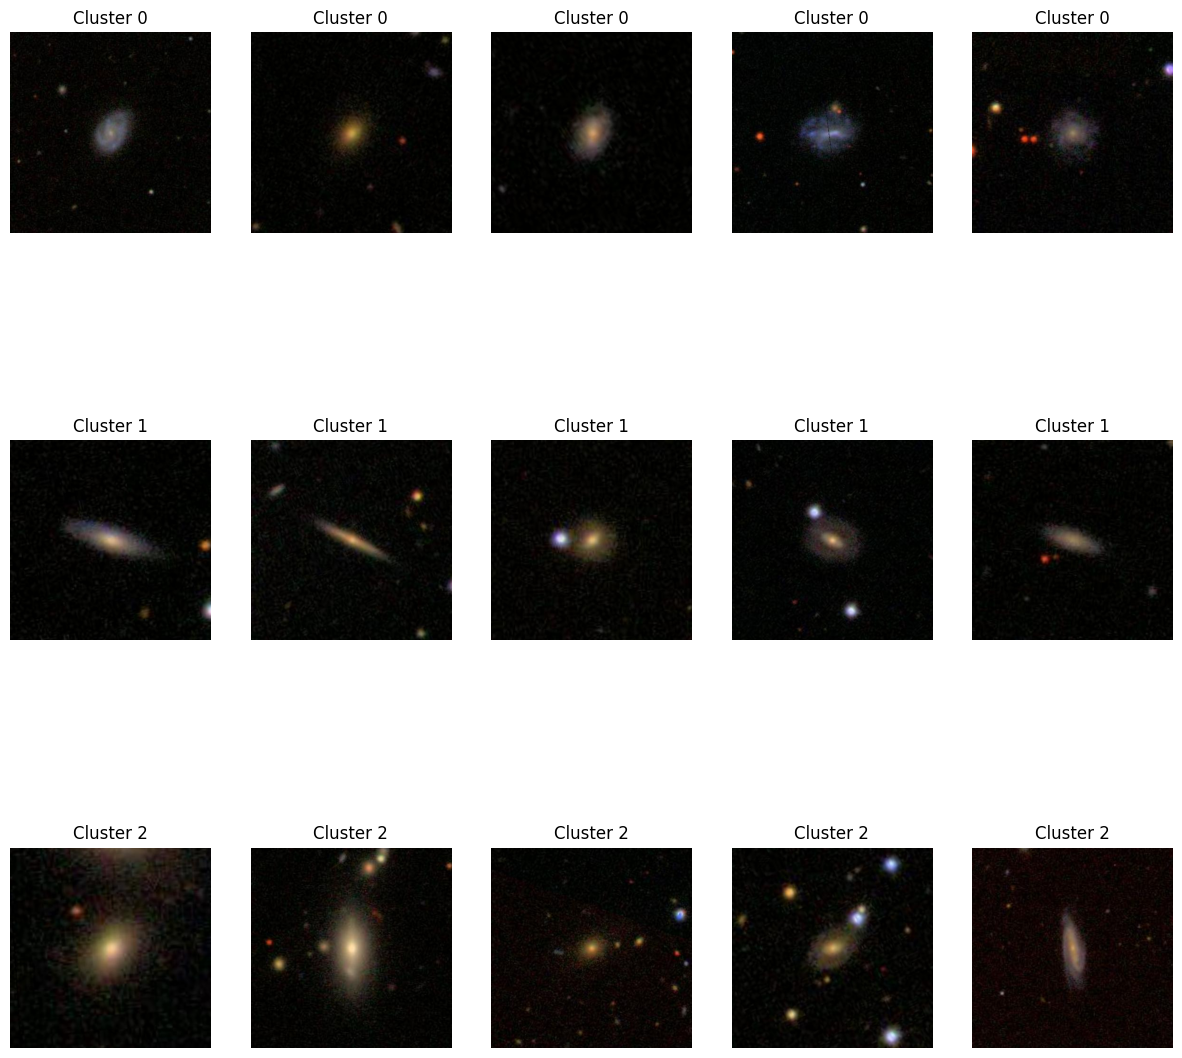

In [26]:
plot_clusters(groups)

### 4-cluster KMeans for x_masks

In [46]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(x_masks)

groups = create_groups(galaxies_train, x_masks, kmeans.labels_)
print('Cardinality of clusters:')
print([len(groups[i]) for i in range(kmeans.get_params()['n_clusters'])])

Cardinality of clusters:
[4013, 3023, 2473, 491]


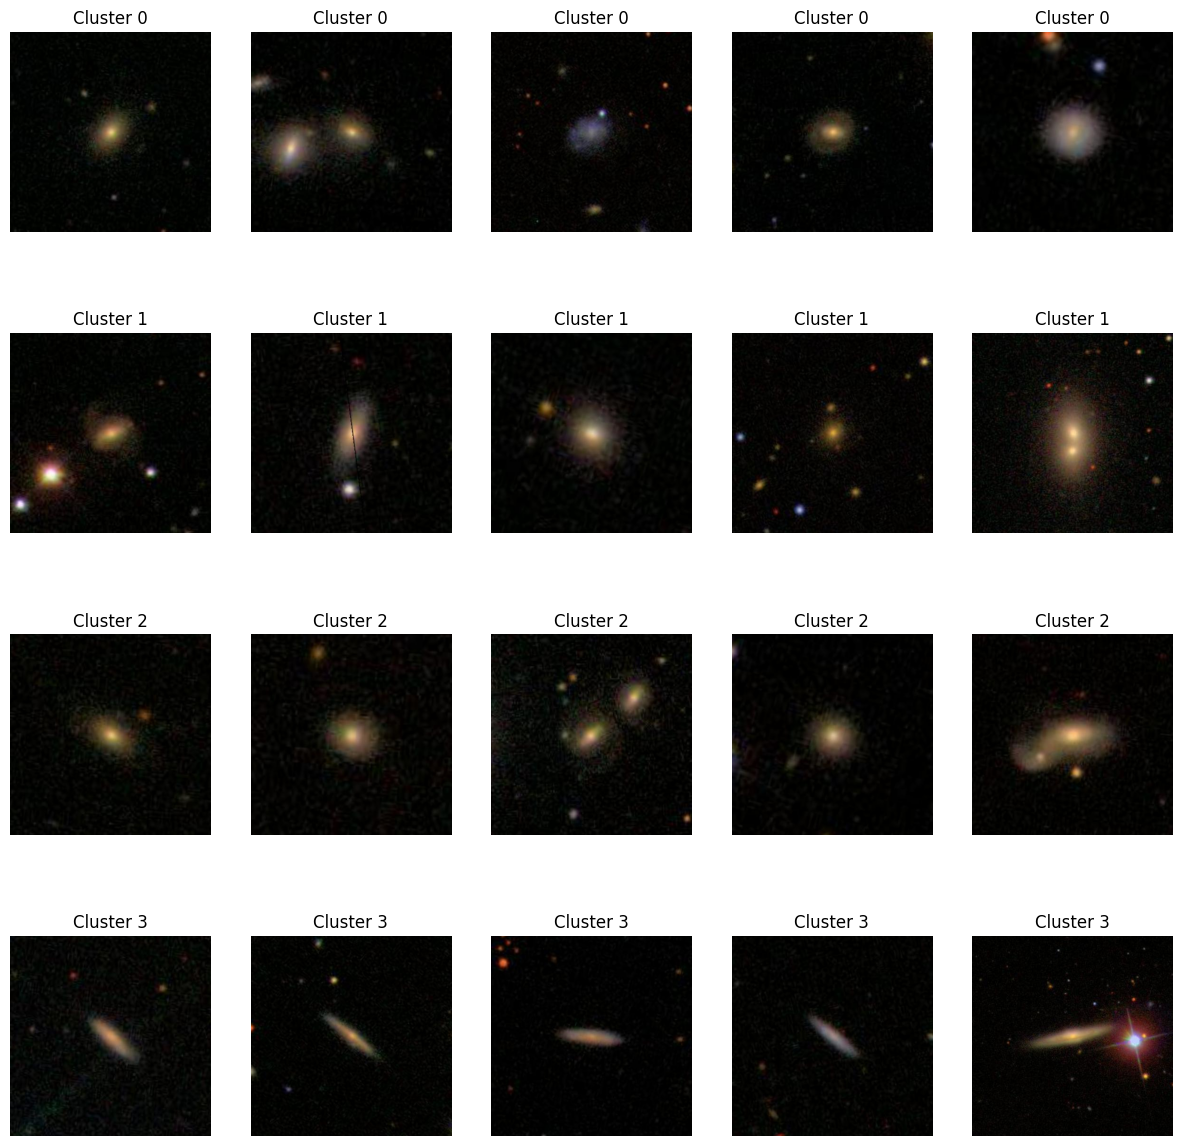

In [111]:
plot_clusters(groups)

Clusters from this method look most promising, lets see more images from each cluster.

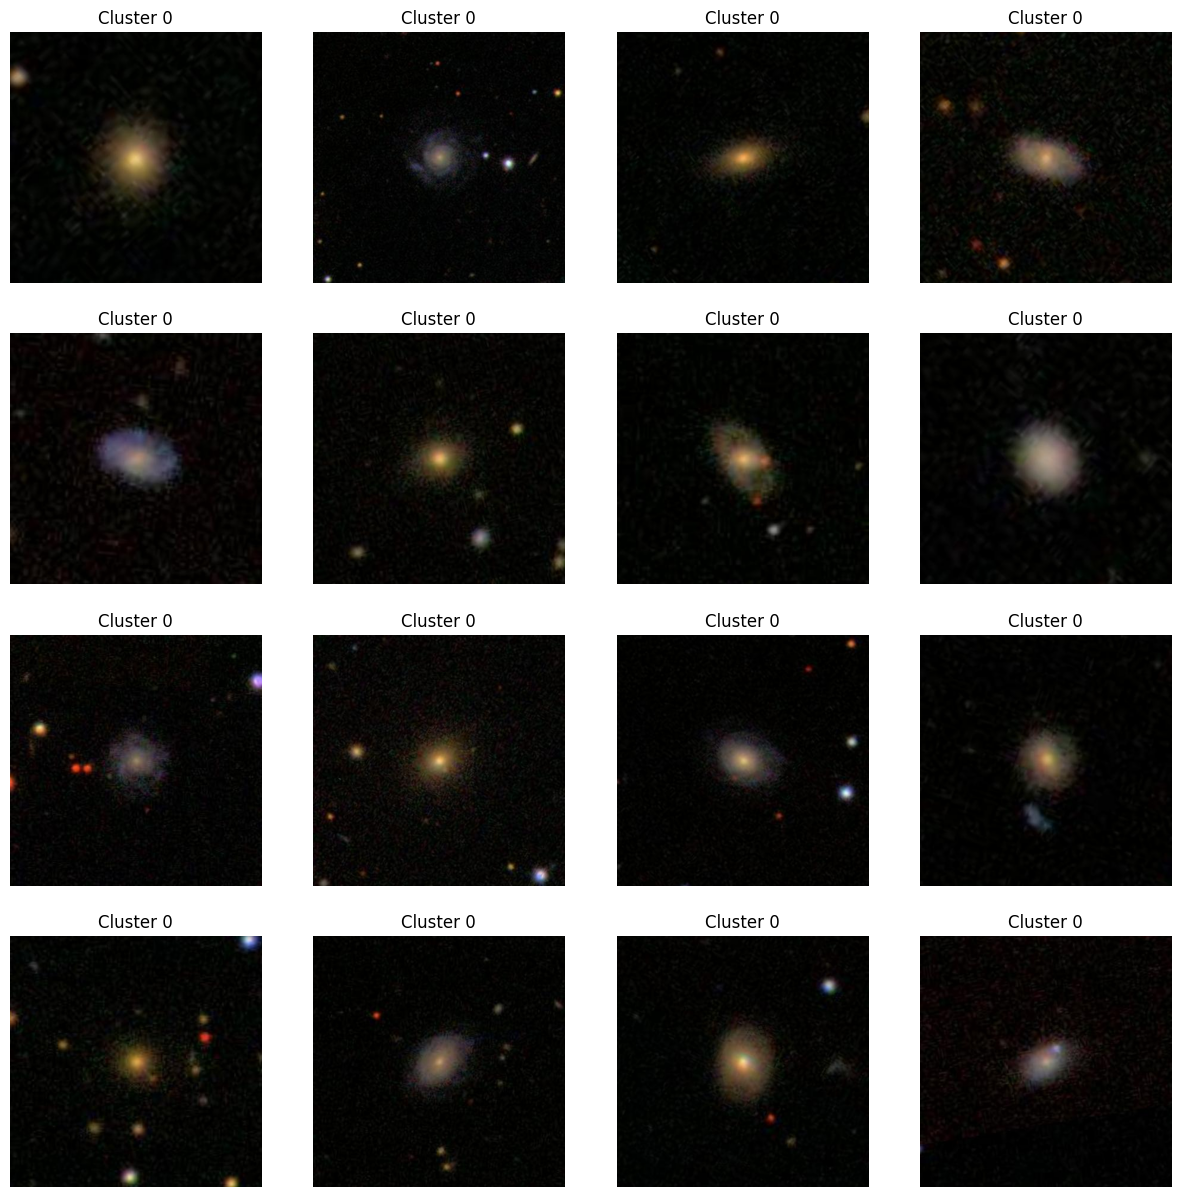

In [60]:
plot_random_images_from_cluster(0, groups)

In cluster 0, there are mostly elliptical galaxies. However, spiral galaxies also appear, especially those with less visible spirals.

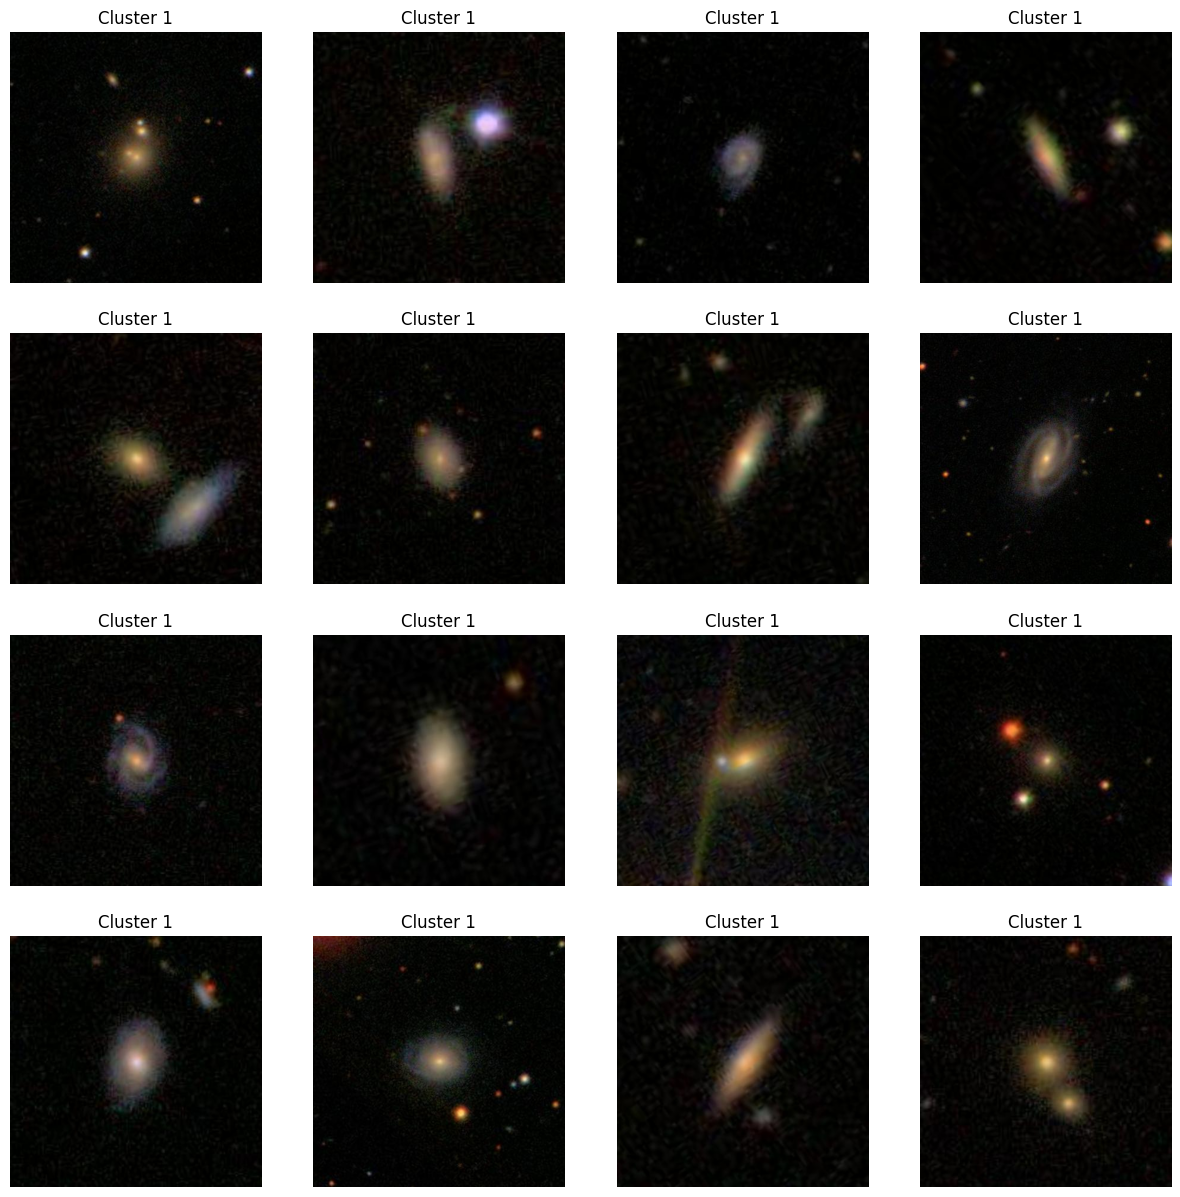

In [65]:
plot_random_images_from_cluster(1, groups)

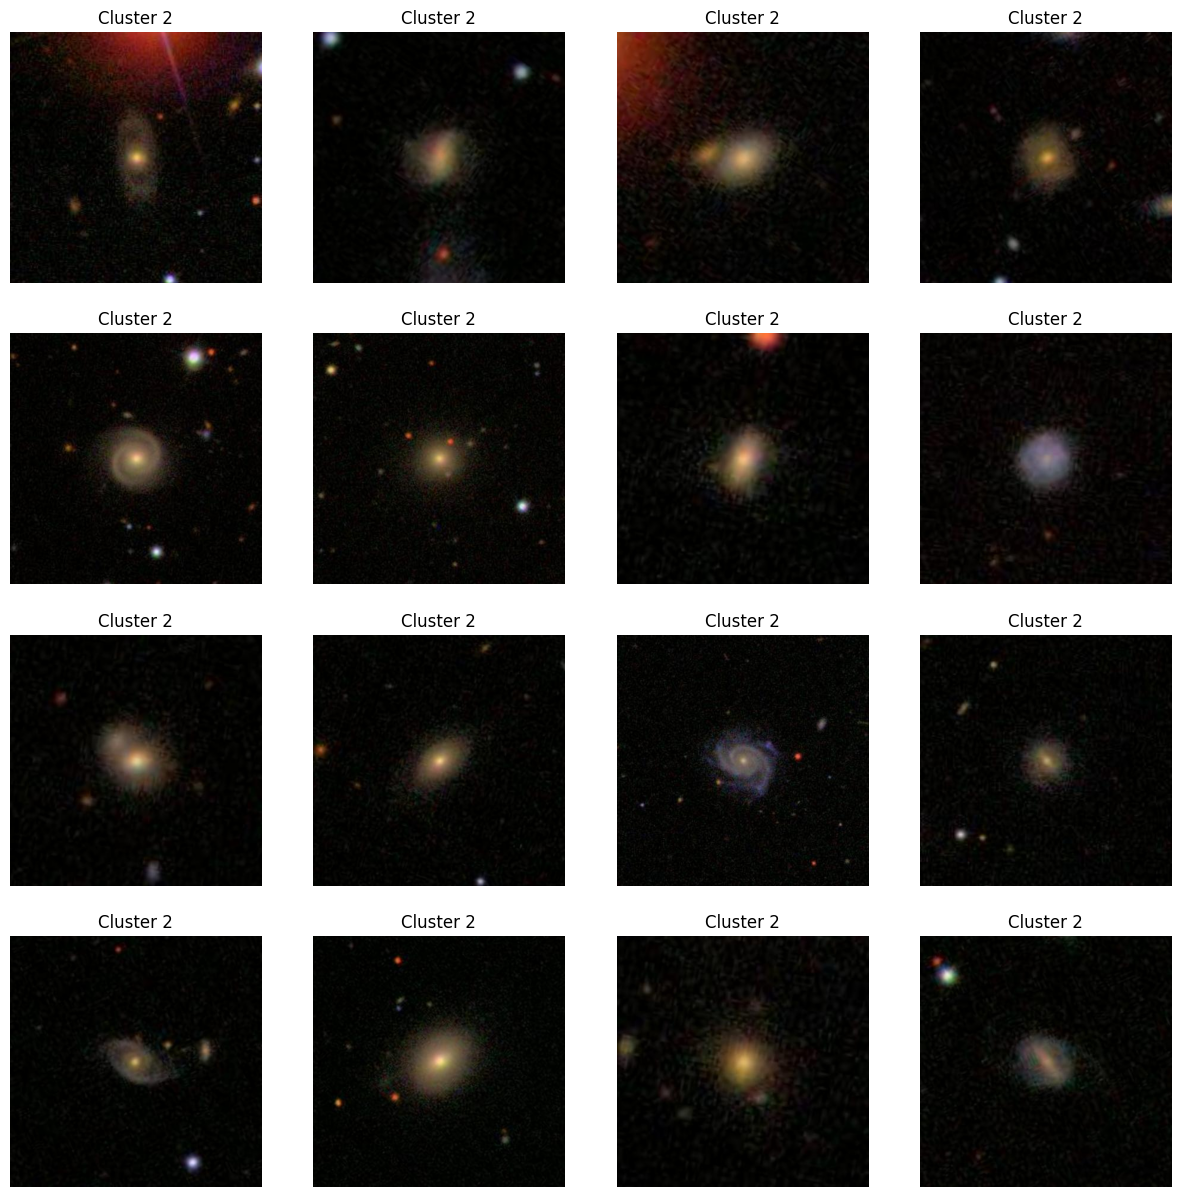

In [71]:
plot_random_images_from_cluster(2, groups)

Clusters 1 and 2 are similar; however, our model fails to recognize this similarity. We attempted a 3-cluster model but did not achieve better results. Both of these clusters predominantly contain spiral galaxies.

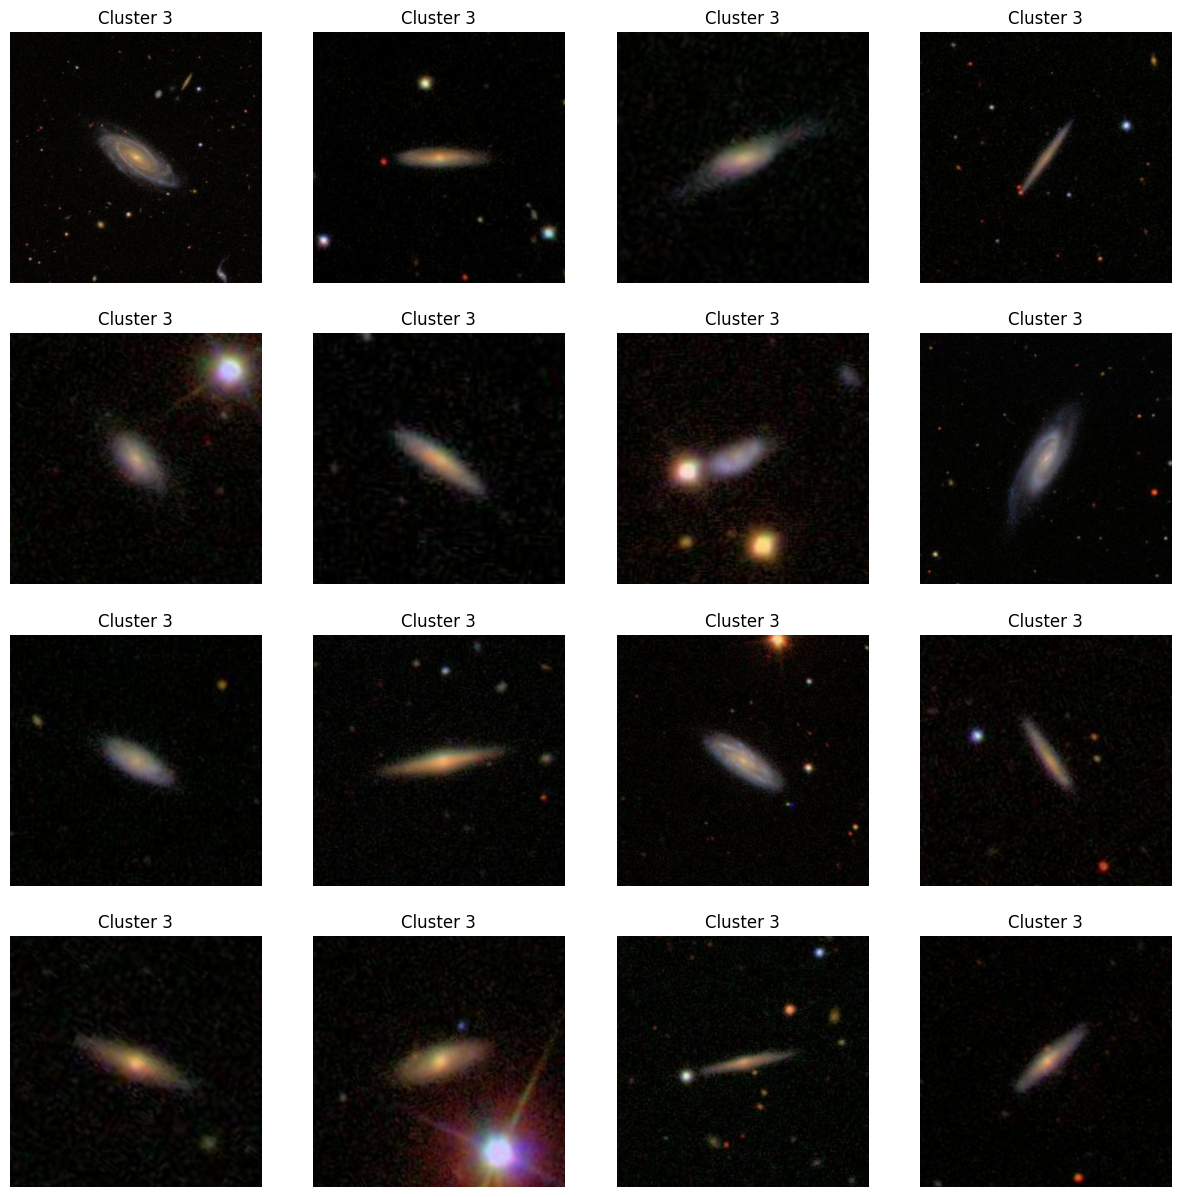

In [77]:
plot_random_images_from_cluster(3, groups)

Galaxies a with more narrow shape tend to land in cluster 3.

## DBSCAN

We will set minPts = 2 * dim, where dim is the dimension of our dataset. This is a standard procedure. 

To determine $\epsilon$ we will use a technique that calculates the average distance between each point and its k nearest neighbors, where k = the MinPts. The average k-distances are then plotted in ascending order on a k-distance graph. We choose the optimal value for $\epsilon$ at the point of maximum curvature (i.e. where the graph has the greatest slope).

Testing DBSCAN for x_masks

In [11]:
neighbors = NearestNeighbors(n_neighbors=2 * x_masks.shape[1])
neighbors_fit = neighbors.fit(x_masks)
distances, indices = neighbors_fit.kneighbors(x_masks)

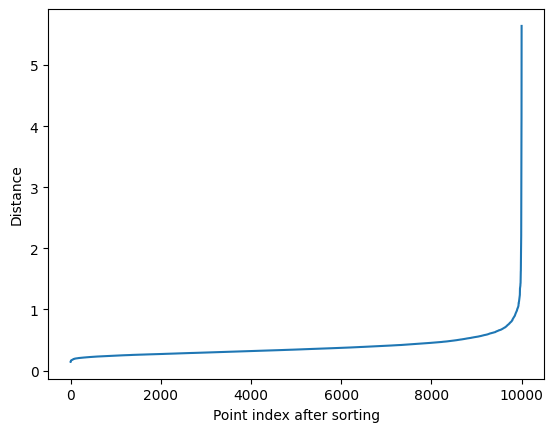

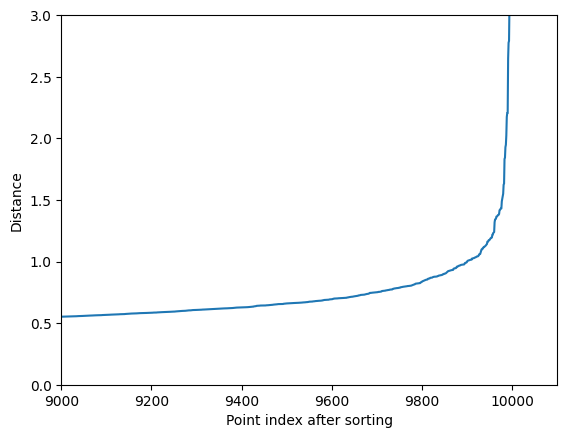

In [14]:
distances = np.sort(distances, axis=0)
plt.plot(distances[:,1])
plt.xlabel('Point index after sorting')
plt.ylabel('Distance')
plt.show()

plt.plot(distances[:,1])
plt.xlabel('Point index after sorting')
plt.ylabel('Distance')
plt.xlim(9000, 10100)
plt.ylim(0, 3)
plt.show()

It looks like optimal value for $\epsilon$ is around 1.25.

In [15]:
dbscan = DBSCAN(eps=1.25, min_samples=2*x_masks.shape[1])
dbscan.fit(x_masks)

DBSCAN(eps=1.25, min_samples=62)

In [16]:
np.unique(dbscan.labels_)

array([-1,  0])

We experimented with different $\epsilon$ values and various datasets, but the DBSCAN results were unsatisfactory. In most cases, it identified only one cluster along with outliers. Consequently, we decided to abandon this method.